# Scheduler Profiling (CFS vs EEVDF)

In [1]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
import re
import math
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import seaborn as sns

In [2]:
print("="*80)
print("Scheduler Profiling (CFS vs EEVDF)")
print("-"*80)

Scheduler Profiling (CFS vs EEVDF)
--------------------------------------------------------------------------------


In [3]:
# ensure figures dir exists
os.makedirs('figures', exist_ok=True)

## Read Execution Logs

In [4]:
LOCAL_PROFILE_DATA_DIR = "../dataset/scheduler_profiling/local"

In [5]:
local_log_data = {}
for filename in os.listdir(LOCAL_PROFILE_DATA_DIR):
    if filename.endswith(".json"):
        key = filename.replace(".json", "")
        if local_log_data.get(key) is None:
            local_log_data[key] = []
        with open(os.path.join(LOCAL_PROFILE_DATA_DIR, filename), "r") as f:
            local_log_data[key] += json.load(f)

In [6]:
local_data = {}
for key, value in local_log_data.items():
    prefix = key.split("-")[:3]
    prefix = "-".join(prefix)
    if local_data.get(prefix) is None:
        local_data[prefix] = []
    local_data[prefix] += value

In [7]:
for k, v in local_data.items():
    local_data[k] = [json.loads(x['data']['body'])['data'] for x in v]

In [8]:
for k, v in local_data.items():
    local_data[k] = [x for x in v if isinstance(x, list) and len(x) > 0]

In [9]:
function_data = {k: v for k, v in local_data.items() if "EEVDF" in k}

In [10]:
local_data = {k: v for k, v in local_data.items() if "CFS" in k}

In [11]:
function_data.keys()

dict_keys(['local-EEVDF-H250P100000Q25000', 'local-EEVDF-H1000P20000Q1447', 'local-EEVDF-H1000P100000Q25000', 'local-EEVDF-H1000P20000Q10000', 'local-EEVDF-H1000P100000Q8000', 'local-EEVDF-H250P10000Q5000', 'local-EEVDF-H250P20000Q1447', 'local-EEVDF-H250P100000Q8000', 'local-EEVDF-H250P20000Q10000', 'local-EEVDF-H1000P100000Q50000', 'local-EEVDF-H1000P20000Q5000', 'local-EEVDF-H250P20000Q5000', 'local-EEVDF-H250P100000Q50000', 'local-EEVDF-H250P10000Q2500', 'local-EEVDF-H1000P10000Q5000', 'local-EEVDF-H1000P10000Q2500'])

In [12]:
# function data -> eevdf
function_data = {
    "Q20P.145 1000Hz": function_data["local-EEVDF-H1000P20000Q1447"],
    "Q20P.145 250Hz": function_data["local-EEVDF-H250P20000Q1447"],
}

In [13]:
# local data -> cfs
local_data = {
    "Q20P.145 1000Hz": local_data["local-CFS-H1000P20000Q1447"],
    "Q20P.145 250Hz": local_data["local-CFS-H250P20000Q1447"],
}

## Calculation

### Throttle Duration

In [14]:
cloud_throttled_duration_data = {}
for k, v in function_data.items():
    cloud_throttled_duration_data[k] = []
    for x in v:
        cloud_throttled_duration_data[k] += [y[1] for y in x[1:]]

local_throttled_duration_data = {}
for k, v in local_data.items():
    local_throttled_duration_data[k] = []
    for x in v:
        local_throttled_duration_data[k] += [y[1] for y in x[1:]]

In [15]:
# convert ns to ms
for k, v in local_throttled_duration_data.items():
    local_throttled_duration_data[k] = [x / 1e6 for x in v]
for k, v in cloud_throttled_duration_data.items():
    cloud_throttled_duration_data[k] = [x / 1e6 for x in v]

### Run Time

In [16]:
def compute_obtained_cpu_times(nested_event_lists):
    obtained_times = []
    for event_list in nested_event_lists:
        if len(event_list) < 2:
            continue
        for (t_prev, _), (t_curr, c_curr) in zip(event_list, event_list[1:]):
            obtained_times.append((t_curr - t_prev) - c_curr)
    return obtained_times

In [17]:
cloud_runtime_data = {}
for k, v in function_data.items():
    cloud_runtime_data[k] = compute_obtained_cpu_times(v)

local_runtime_data = {}
for k, v in local_data.items():
    local_runtime_data[k] = compute_obtained_cpu_times(v)

In [18]:
# convert ns to ms
for k, v in local_runtime_data.items():
    local_runtime_data[k] = [x / 1e6 for x in v]
for k, v in cloud_runtime_data.items():
    cloud_runtime_data[k] = [x / 1e6 for x in v]

In [19]:
for k, v in cloud_runtime_data.items():
    cloud_runtime_data[k] = [x for x in v if x < 500]
for k, v in local_runtime_data.items():
    local_runtime_data[k] = [x for x in v if x < 500]

### Throttle Interval

In [20]:
def calculate_throttle_interval(tuple_list):
    intervals = []
    for chunk in tuple_list:
        for prev, nxt in zip(chunk, chunk[1:]):
            t_prev = prev[0]
            t_next = nxt[0]
            intervals.append(t_next - t_prev)
    return intervals

In [21]:
cloud_throttle_interval_data = {}

for k, v in function_data.items():
    cloud_throttle_interval_data[k] = calculate_throttle_interval(v)

local_throttle_interval_data = {}
for k, v in local_data.items():
    local_throttle_interval_data[k] = calculate_throttle_interval(v)

In [22]:
# convert ns to ms
for k, v in local_throttle_interval_data.items():
    local_throttle_interval_data[k] = [x / 1e6 for x in v]
for k, v in cloud_throttle_interval_data.items():
    cloud_throttle_interval_data[k] = [x / 1e6 for x in v]

Figure saved to figures/scheduler_profiling_cfs_vs_eedvf.pdf


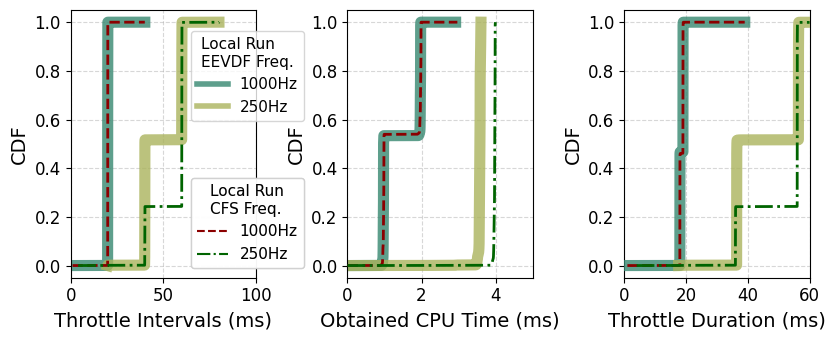

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.4, 3.5))
palette = sns.color_palette("gist_earth", n_colors=2)
color_map = {flavor: palette[i] for i, flavor in enumerate(cloud_throttle_interval_data)}

dashed_line_styles_list = ['dashed', 'dashdot']
dashed_line_colors_list = ['darkred', 'darkgreen']

for i, flavor in enumerate(cloud_throttle_interval_data):
    data = [x for x in cloud_throttle_interval_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax1.plot(data, yvals, label=flavor, lw=8, color=color_map[flavor], alpha=0.8)

for i, flavor in enumerate(local_throttle_interval_data):
    data = [x for x in local_throttle_interval_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax1.plot(data, yvals, label=flavor, linestyle=dashed_line_styles_list[i%len(dashed_line_styles_list)], lw=2, zorder=1000, color=dashed_line_colors_list[i%len(dashed_line_colors_list)])

ax1.grid(alpha=0.5, linestyle='--')
ax1.set_xlabel("Throttle Intervals (ms)", fontsize=14)
ax1.set_ylabel("CDF", fontsize=14)
ax1.set_xlim(0, 100)
ax1.tick_params(axis='both', labelsize=12)

for i, flavor in enumerate(cloud_runtime_data):
    data = [x for x in cloud_runtime_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax2.plot(data, yvals, label=flavor, lw=8, color=color_map[flavor], alpha=0.8)

for i, flavor in enumerate(local_runtime_data):
    data = [x for x in local_runtime_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax2.plot(data, yvals, label=flavor, linestyle=dashed_line_styles_list[i%len(dashed_line_styles_list)], lw=2, zorder=1000, color=dashed_line_colors_list[i%len(dashed_line_colors_list)])

cloud_handles = [
    mlines.Line2D([], [], color=color_map['Q20P.145 1000Hz'], label="1000Hz", lw=4, alpha=0.8),
    mlines.Line2D([], [], color=color_map['Q20P.145 250Hz'], label="250Hz", lw=4, alpha=0.8)
]
local_handles = [
    mlines.Line2D([], [], color=dashed_line_colors_list[i], linestyle=dashed_line_styles_list[i%len(dashed_line_styles_list)], lw=1.5, label=lbl)
    for i, lbl in enumerate(["1000Hz", "250Hz"])
]
leg1 = ax1.legend(handles=cloud_handles, title="Local Run\nEEVDF Freq.",
                  fontsize=11, title_fontsize=11,
                  loc='upper right', bbox_to_anchor=(1.3, 0.95))
ax1.add_artist(leg1)
leg2 = ax1.legend(handles=local_handles, title="Local Run\nCFS Freq.",
                  fontsize=11, title_fontsize=11,
                  loc='upper right', bbox_to_anchor=(1.3, 0.4))
ax1.add_artist(leg2)

ax2.grid(alpha=0.5, linestyle='--')
ax2.set_xlabel("Obtained CPU Time (ms)", fontsize=14)
ax2.set_ylabel("CDF", fontsize=14)
ax2.set_xlim(0, 5)
ax2.tick_params(axis='both', labelsize=12)

for i, flavor in enumerate(cloud_throttled_duration_data):
    data = [x for x in cloud_throttled_duration_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax3.plot(data, yvals, label=flavor, zorder=100 , lw=8, color=color_map[flavor], alpha=0.8)

for i, flavor in enumerate(local_throttled_duration_data):
    data = [x for x in local_throttled_duration_data[flavor] if x > 0]
    data.sort()
    yvals = np.arange(1, len(data) + 1) / len(data)
    ax3.plot(data, yvals, label=flavor, linestyle=dashed_line_styles_list[i%len(dashed_line_styles_list)], lw=2, zorder=1000, color=dashed_line_colors_list[i%len(dashed_line_colors_list)])

ax3.grid(alpha=0.5, linestyle='--')
ax3.set_xlabel("Throttle Duration (ms)", fontsize=14)
ax3.set_ylabel("CDF", fontsize=14)
ax3.set_xlim(0, 60)
ax3.tick_params(axis='both', labelsize=12)

plt.tight_layout()
fig.savefig("figures/scheduler_profiling_cfs_vs_eedvf.pdf")
print("Figure saved to figures/scheduler_profiling_cfs_vs_eedvf.pdf")
plt.show()
